# Experiment: Momentum Transformer Dual Momentum

目的:
- デュアルモメンタムにDecoder-Only TFT (PyTorch) を適用
- EQW / DualMom / Momentum Transformer を同一条件で比較
- エクイティカーブ (累積リターン曲線) を可視化

変更点:
- 日次特徴量（論文準拠）を作成し、seq_len=252で学習
- ターゲットはボラ調整日次リターン（翌日）
- ポートフォリオは月次リバランスのまま比較

注意:
- 未来情報リーク防止（特徴量は当日まで、ターゲットは翌日）
- 学習/検証/テストは時系列分割

参照:
- doc/Trading with the Momentum Transformer An Intelligent and Interpretable Architecture.pdf
- doc/kieranjwood-trading-momentum-transformer.txt


In [46]:
from __future__ import annotations
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
# 出力ディレクトリ
BASE_DIR = Path("/Users/kencharoff/workspace/projects/momentum/test")
DATA_PATH = Path("/Users/kencharoff/workspace/strategy/momentum/data/prices.csv")
OUTPUT_DIR = BASE_DIR / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"
TABLE_DIR = OUTPUT_DIR / "tables"
for d in [OUTPUT_DIR, FIG_DIR, TABLE_DIR]:
    d.mkdir(parents=True, exist_ok=True)
# Matplotlibのキャッシュ先（権限エラー回避）
MPL_DIR = OUTPUT_DIR / ".mpl"
MPL_DIR.mkdir(parents=True, exist_ok=True)
os.environ["MPLCONFIGDIR"] = str(MPL_DIR)
import matplotlib.pyplot as plt
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
CONFIG = {
    "tickers": [
        "SPY", "IWM", "EFA", "EEM", "AGG", "TLT",
        "LQD", "HYG", "EMB", "GLD", "DBC", "VNQ",
    ],
    "start": "2005-01-01",
    "rebalance_freq": "ME",
    "transaction_cost_bps": 10,
    "top_k": 3,
    "risk_window_days": 252,
    "seq_len": 252,
    "train_end_year": 2016,
    "val_end_year": 2019,
}
TRAIN_PARAMS = {
    "hidden_size": 32,
    "dropout": 0.1,
    "num_heads": 4,
    "embed_dim": 16,
    "lr": 1e-3,
    "batch_size": 128,
    "epochs": 50,
    "patience": 8,
    "grad_clip": 1.0,
    "lambda_turnover": 0.01,
}
VOL_LOOKBACK = 60
VOL_TARGET = 0.15
VOL_THRESHOLD = 5
HALFLIFE_WINSORISE = 252
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

In [47]:
def load_prices(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, header=[0, 1], skiprows=[2], index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df["Adj Close"]
    df = df[~df.index.duplicated(keep="last")]
    df = df.astype(float).ffill()
    return df

prices = load_prices(DATA_PATH)
prices = prices[CONFIG["tickers"]]
prices = prices.loc[CONFIG["start"]:]

# 日次リターン（リスク推定用）
daily_ret = prices.pct_change()

# 月次系列
month_end_prices = prices.resample(CONFIG["rebalance_freq"]).last()
monthly_ret = month_end_prices.pct_change()

print("Daily range:", prices.index.min(), prices.index.max())
print("Monthly points:", len(monthly_ret))


Daily range: 2005-01-03 00:00:00 2026-02-09 00:00:00
Monthly points: 254


In [48]:
def calc_returns(srs: pd.Series, day_offset: int = 1) -> pd.Series:
    return srs / srs.shift(day_offset) - 1.0
def calc_daily_vol(daily_returns: pd.Series) -> pd.Series:
    return daily_returns.ewm(span=VOL_LOOKBACK, min_periods=VOL_LOOKBACK).std()
def calc_vol_scaled_returns(daily_returns: pd.Series, daily_vol: pd.Series) -> pd.Series:
    annualised_vol = daily_vol * np.sqrt(252)
    return daily_returns * VOL_TARGET / annualised_vol.shift(1)
def macd_signal(srs: pd.Series, short: int, long: int) -> pd.Series:
    def _calc_halflife(timescale: int) -> float:
        return np.log(0.5) / np.log(1 - 1 / timescale)
    macd = srs.ewm(halflife=_calc_halflife(short)).mean() - srs.ewm(
        halflife=_calc_halflife(long)
    ).mean()
    q = macd / srs.rolling(63).std()
    return q / q.rolling(252).std()
def build_features(daily_prices: pd.DataFrame) -> pd.DataFrame:
    frames = []
    for ticker in daily_prices.columns:
        close = daily_prices[ticker].dropna()
        # winsorize with EWM mean/std (no backfill to avoid lookahead)
        ewm = close.ewm(halflife=HALFLIFE_WINSORISE)
        means = ewm.mean()
        stds = ewm.std()
        srs = close.clip(means - VOL_THRESHOLD * stds, means + VOL_THRESHOLD * stds)
        daily_returns = calc_returns(srs)
        daily_vol = calc_daily_vol(daily_returns)
        target_returns = calc_vol_scaled_returns(daily_returns, daily_vol).shift(-1)
        def norm_ret(offset: int) -> pd.Series:
            return calc_returns(srs, offset) / daily_vol / np.sqrt(offset)
        df_t = pd.DataFrame(
            {
                "norm_daily_return": norm_ret(1),
                "norm_monthly_return": norm_ret(21),
                "norm_quarterly_return": norm_ret(63),
                "norm_biannual_return": norm_ret(126),
                "norm_annual_return": norm_ret(252),
                "macd_8_24": macd_signal(srs, 8, 24),
                "macd_16_48": macd_signal(srs, 16, 48),
                "macd_32_96": macd_signal(srs, 32, 96),
                "target": target_returns,
            },
            index=srs.index,
        )
        df_t["ticker"] = ticker
        frames.append(df_t)
    df_long = pd.concat(frames)
    df_long = df_long.dropna().reset_index().rename(columns={"index": "date"})
    df_long["date"] = pd.to_datetime(df_long["date"])
    df_long["year"] = df_long["date"].dt.year
    return df_long
features_long = build_features(prices)
feature_cols = [c for c in features_long.columns if c not in {"date", "ticker", "target", "year"}]
# dual momentum base score (monthly)
ret_12_1m = month_end_prices.shift(1) / month_end_prices.shift(12) - 1
print("features:", feature_cols)
features_long.head()


features: ['norm_daily_return', 'norm_monthly_return', 'norm_quarterly_return', 'norm_biannual_return', 'norm_annual_return', 'macd_8_24', 'macd_16_48', 'macd_32_96']


date  norm_daily_return  norm_monthly_return  norm_quarterly_return  \
0 2006-03-31           0.042042             0.302994               0.945039   
1 2006-04-03          -0.142516             0.465887               1.073797   
2 2006-04-04           1.180259             0.913669               0.803249   
3 2006-04-05           0.643542             1.133932               0.781959   
4 2006-04-06          -0.202491             1.015970               0.751735   

   norm_biannual_return  norm_annual_return  macd_8_24  macd_16_48  \
0              1.108063            1.435743   1.610196    2.497021   
1              1.057761            1.426166   1.629996    2.587377   
2              1.229665            1.443178   1.655577    2.575248   
3              1.510783            1.460743   1.694418    2.546728   
4              1.758038            1.396127   1.702011    2.517796   

   macd_32_96    target ticker  year  
0    2.972766 -0.001326    SPY  2006  
1    3.093360  0.011186    SPY  2006  
2    3.061501  0.006007    SPY  2006  
3    2.998987 -0.001885    SPY  2006  
4    2.948186 -0.018199    SPY  2006

In [49]:
def make_sequences(df: pd.DataFrame, feature_cols: list[str], seq_len: int):
    X_list, y_list, ticker_list, date_list = [], [], [], []
    for ticker, df_t in df.groupby("ticker"):
        df_t = df_t.sort_values("date")
        values = df_t[feature_cols].values
        targets = df_t["target"].values
        dates = df_t["date"].values
        for i in range(seq_len - 1, len(df_t)):
            X = values[i - seq_len + 1 : i + 1]
            y = targets[i]
            if np.isnan(y) or np.isnan(X).any():
                continue
            X_list.append(X)
            y_list.append(y)
            ticker_list.append(ticker)
            date_list.append(dates[i])
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    dates = pd.to_datetime(date_list)
    return X, y, np.array(ticker_list), dates
X, y, tickers_raw, dates = make_sequences(features_long, feature_cols, CONFIG["seq_len"])
all_tickers = sorted(features_long["ticker"].unique().tolist())
ticker_to_id = {t: i for i, t in enumerate(all_tickers)}
id_to_ticker = {i: t for t, i in ticker_to_id.items()}
ticker_ids = np.array([ticker_to_id[t] for t in tickers_raw], dtype=np.int64)
years = dates.year
train_mask = years <= CONFIG["train_end_year"]
val_mask = (years > CONFIG["train_end_year"]) & (years <= CONFIG["val_end_year"])
test_mask = years > CONFIG["val_end_year"]
scaler = StandardScaler()
scaler.fit(X[train_mask].reshape(-1, X.shape[-1]))
X_scaled = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
class SeqDataset(Dataset):
    def __init__(self, X, y, ticker_ids, dates):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.ticker_ids = torch.tensor(ticker_ids, dtype=torch.long)
        self.dates = pd.to_datetime(dates)
        self.dates_int = self.dates.view("int64")
        self.dates_tensor = torch.tensor(self.dates_int, dtype=torch.long)
        self.ticker_ids_np = np.array(ticker_ids)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.ticker_ids[idx], self.y[idx], self.dates_tensor[idx]
train_ds = SeqDataset(X_scaled[train_mask], y[train_mask], ticker_ids[train_mask], dates[train_mask])
val_ds = SeqDataset(X_scaled[val_mask], y[val_mask], ticker_ids[val_mask], dates[val_mask])
test_ds = SeqDataset(X_scaled[test_mask], y[test_mask], ticker_ids[test_mask], dates[test_mask])
train_loader = DataLoader(train_ds, batch_size=TRAIN_PARAMS["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=TRAIN_PARAMS["batch_size"], shuffle=False)
test_loader = DataLoader(test_ds, batch_size=TRAIN_PARAMS["batch_size"], shuffle=False)
print("train/val/test sizes:", len(train_ds), len(val_ds), len(test_ds))


train/val/test sizes: 27893 9048 18396


In [50]:
class GLU(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, dropout: float = 0.0):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.gate = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x) * torch.sigmoid(self.gate(x))


class GRN(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int | None = None, dropout: float = 0.0):
        super().__init__()
        self.out_dim = out_dim if out_dim is not None else in_dim
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, self.out_dim)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(dropout)
        self.glu = GLU(self.out_dim, self.out_dim, dropout=dropout)
        self.skip = nn.Linear(in_dim, self.out_dim) if self.out_dim != in_dim else None
        self.norm = nn.LayerNorm(self.out_dim)

    def forward(self, x, context=None):
        h = self.fc1(x)
        if context is not None:
            h = h + context
        h = self.elu(h)
        h = self.fc2(h)
        h = self.dropout(h)
        h = self.glu(h)
        skip = self.skip(x) if self.skip is not None else x
        return self.norm(skip + h)


class VSN(nn.Module):
    def __init__(self, num_features: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.feature_grns = nn.ModuleList(
            [GRN(1, hidden_dim, hidden_dim, dropout) for _ in range(num_features)]
        )
        self.weights_grn = GRN(num_features, hidden_dim, num_features, dropout)

    def forward(self, x, static_context=None):
        # x: (B, T, F)
        if static_context is not None:
            context = static_context.unsqueeze(1)
        else:
            context = None

        weights = self.weights_grn(x, context)
        weights = torch.softmax(weights, dim=-1)

        transformed = []
        for i in range(self.num_features):
            xi = x[..., i : i + 1]
            transformed.append(self.feature_grns[i](xi))
        transformed = torch.stack(transformed, dim=-1)  # (B, T, H, F)

        weighted = (transformed * weights.unsqueeze(-2)).sum(dim=-1)
        return weighted, weights


def causal_mask(seq_len: int, device):
    mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
    return mask.bool()


In [51]:
class DecoderOnlyTFT(nn.Module):
    def __init__(self, num_features, num_tickers, hidden_dim, num_heads, embed_dim, dropout=0.1):
        super().__init__()
        self.ticker_emb = nn.Embedding(num_tickers, embed_dim)
        self.static_grn = GRN(embed_dim, hidden_dim, hidden_dim, dropout)
        self.vsn = VSN(num_features, hidden_dim, dropout)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn_norm = nn.LayerNorm(hidden_dim)
        self.decoder_grn = GRN(hidden_dim, hidden_dim, hidden_dim, dropout)
        self.out_score = nn.Linear(hidden_dim, 1)
        self.out_gate = nn.Linear(hidden_dim, 1)
    def forward(self, x, ticker_ids):
        # x: (B, T, F)
        static = self.ticker_emb(ticker_ids)
        static = self.static_grn(static)
        vsn_out, _ = self.vsn(x, static)
        h0 = static.unsqueeze(0)
        c0 = static.unsqueeze(0)
        lstm_out, _ = self.lstm(vsn_out, (h0, c0))
        mask = causal_mask(lstm_out.size(1), lstm_out.device)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out, attn_mask=mask)
        attn_out = self.attn_norm(attn_out + lstm_out)
        dec = self.decoder_grn(attn_out)
        last = dec[:, -1, :]
        score = torch.tanh(self.out_score(last))
        gate = torch.sigmoid(self.out_gate(last))
        pos = score * gate
        return pos, score, gate
def sharpe_loss(pos, y, eps=1e-9):
    pos = pos.squeeze(-1)
    captured = pos * y
    mean = captured.mean()
    std = captured.std(unbiased=False) + eps
    return -(mean / std) * (252.0 ** 0.5)
def turnover_penalty(pos: torch.Tensor, dates: torch.Tensor, tickers: torch.Tensor) -> torch.Tensor:
    # approximate turnover within batch by sorting by (ticker, date)
    pos = pos.squeeze(-1)
    dates_np = dates.detach().cpu().numpy()
    tickers_np = tickers.detach().cpu().numpy()
    order = sorted(range(len(pos)), key=lambda i: (tickers_np[i], dates_np[i]))
    pos_sorted = pos[order]
    tick_sorted = tickers[order]
    # compute |pos_t - pos_t-1| within same ticker
    diffs = []
    for i in range(1, len(pos_sorted)):
        if tick_sorted[i].item() == tick_sorted[i-1].item():
            diffs.append(torch.abs(pos_sorted[i] - pos_sorted[i-1]))
    if len(diffs) == 0:
        return torch.tensor(0.0, device=pos.device)
    return torch.mean(torch.stack(diffs))
def eval_sharpe(model, loader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for Xb, tb, yb, db in loader:
            Xb = Xb.to(DEVICE)
            tb = tb.to(DEVICE)
            yb = yb.to(DEVICE)
            out, _, _ = model(Xb, tb)
            out = out.squeeze(-1)
            preds.append(out.detach().cpu().numpy())
            targets.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    captured = preds * targets
    mean = captured.mean()
    std = captured.std() + 1e-9
    return (mean / std) * (252.0 ** 0.5)
def train_model(model, train_loader, val_loader, params):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=params["lr"])
    best_val = -1e9
    best_state = None
    patience = 0
    for epoch in range(1, params["epochs"] + 1):
        model.train()
        losses = []
        for Xb, tb, yb, db in train_loader:
            Xb = Xb.to(DEVICE)
            tb = tb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            out, _, _ = model(Xb, tb)
            loss = sharpe_loss(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), params["grad_clip"])
            opt.step()
            losses.append(loss.item())
        val_sharpe = eval_sharpe(model, val_loader)
        avg_loss = float(np.mean(losses)) if losses else float("nan")
        print(f"Epoch {epoch:02d} | train loss {avg_loss:.4f} | val sharpe {val_sharpe:.3f}")
        if val_sharpe > best_val + 1e-4:
            best_val = val_sharpe
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= params["patience"]:
                print("Early stopping")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model
model = DecoderOnlyTFT(
    num_features=len(feature_cols),
    num_tickers=len(all_tickers),
    hidden_dim=TRAIN_PARAMS["hidden_size"],
    num_heads=TRAIN_PARAMS["num_heads"],
    embed_dim=TRAIN_PARAMS["embed_dim"],
    dropout=TRAIN_PARAMS["dropout"],
)
model = train_model(model, train_loader, val_loader, TRAIN_PARAMS)


Epoch 01 | train loss -0.1919 | val sharpe 1.009
Epoch 02 | train loss -0.5712 | val sharpe 0.560
Epoch 03 | train loss -0.8089 | val sharpe 0.374
Epoch 04 | train loss -1.0137 | val sharpe 0.305
Epoch 05 | train loss -1.0582 | val sharpe -0.059
Epoch 06 | train loss -1.1521 | val sharpe 0.377
Epoch 07 | train loss -1.2780 | val sharpe 0.186
Epoch 08 | train loss -1.3432 | val sharpe 0.177
Epoch 09 | train loss -1.4560 | val sharpe 0.552
Early stopping


In [52]:
@torch.no_grad()
def predict_positions(model, dataset: SeqDataset, batch_size: int = 512):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    preds = []
    for Xb, tb, _, db in loader:
        Xb = Xb.to(DEVICE)
        tb = tb.to(DEVICE)
        out, _, _ = model(Xb, tb)
        out = out.squeeze(-1)
        preds.append(out.cpu().numpy())
    return np.concatenate(preds)
preds_test = predict_positions(model, test_ds, batch_size=TRAIN_PARAMS["batch_size"])
pred_df = pd.DataFrame({
    "date": test_ds.dates,
    "ticker": [id_to_ticker[i] for i in test_ds.ticker_ids_np],
    "pred": preds_test,
})
pred_scores = pred_df.pivot(index="date", columns="ticker", values="pred").sort_index()
# 月末の予測値を採用
pred_scores = pred_scores.resample(CONFIG["rebalance_freq"]).last()
pred_scores = pred_scores.reindex(monthly_ret.index).sort_index()
# デュアルモメンタムスコア
def dual_mom_score(rel_score: pd.DataFrame, abs_score: pd.DataFrame) -> pd.DataFrame:
    score = rel_score.copy()
    score = score.where(abs_score > 0)
    return score
_dm_base = ret_12_1m.reindex(monthly_ret.index)
dual_mom_score_df = dual_mom_score(_dm_base, _dm_base)
# 重み付け
def inverse_vol_weights(cov: pd.DataFrame) -> pd.Series:
    vol = np.sqrt(np.diag(cov.values))
    inv = 1 / np.where(vol == 0, np.nan, vol)
    w = inv / np.nansum(inv)
    return pd.Series(w, index=cov.index)
def build_weights(score_df: pd.DataFrame, mode: str) -> pd.DataFrame:
    tickers = CONFIG["tickers"]
    w = pd.DataFrame(0.0, index=score_df.index, columns=tickers)
    for dt in score_df.index:
        score = score_df.loc[dt].dropna()
        if score.empty:
            continue
        if mode == "absolute":
            eligible = score[score > 0].index
        elif mode == "relative":
            eligible = score.sort_values(ascending=False).head(CONFIG["top_k"]).index
        else:
            raise ValueError("Unknown mode")
        if len(eligible) == 0:
            continue
        hist = daily_ret.loc[:dt].tail(CONFIG["risk_window_days"])
        hist = hist[eligible].dropna(how="all")
        cov = hist.cov()
        cov = cov.loc[eligible, eligible]
        cov = cov.dropna(axis=0, how="all").dropna(axis=1, how="all")
        if cov.shape[0] == 0:
            continue
        cov = cov.fillna(0.0)
        cov = cov + np.eye(cov.shape[0]) * 1e-6
        try:
            weights = inverse_vol_weights(cov)
        except Exception:
            weights = pd.Series(1.0 / len(eligible), index=eligible)
        weights = weights / weights.sum()
        w.loc[dt, weights.index] = weights.values
    return w
strategies = {
    "MT": {"scores": pred_scores, "mode": "relative"},
    "DualMom": {"scores": dual_mom_score_df, "mode": "relative"},
}
weights = {name: build_weights(spec["scores"], spec["mode"]) for name, spec in strategies.items()}
N = len(CONFIG["tickers"])
w_eqw = pd.DataFrame(1.0 / N, index=monthly_ret.index, columns=CONFIG["tickers"])
weights["EQW"] = w_eqw
# リターン計算
results = {}
turnovers = {}
for name, w in weights.items():
    w = w.reindex(monthly_ret.index).fillna(0.0)
    gross = (w.shift(1) * monthly_ret).sum(axis=1)
    turnover = w.diff().abs().sum(axis=1)
    cost = turnover.shift(1) * (CONFIG["transaction_cost_bps"] / 10000.0)
    net = gross - cost
    results[name] = net
    turnovers[name] = turnover
returns_df = pd.DataFrame(results)
# テスト期間のみ可視化
returns_test = returns_df.loc[returns_df.index.year > CONFIG["val_end_year"]]
# パフォーマンス指標
def max_drawdown(nav: pd.Series) -> tuple[float, int]:
    hwm = nav.cummax()
    dd = nav / hwm - 1.0
    max_dd = dd.min()
    duration = 0
    max_duration = 0
    for v in dd:
        if v < 0:
            duration += 1
        else:
            duration = 0
        max_duration = max(max_duration, duration)
    return float(max_dd), int(max_duration)
def perf_stats(returns: pd.Series, periods_per_year: int = 12) -> dict:
    r = returns.dropna()
    if r.empty:
        return {k: np.nan for k in ["AnnReturn", "CAGR", "Vol", "Sharpe", "MaxDD", "MaxDDDur", "Skew", "Kurtosis", "HitRate"]}
    ann_ret = r.mean() * periods_per_year
    cagr = (1 + r).prod() ** (periods_per_year / len(r)) - 1
    vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / vol if vol != 0 else np.nan
    max_dd, max_dd_dur = max_drawdown((1 + r).cumprod())
    hit_rate = (r > 0).mean()
    return {
        "AnnReturn": ann_ret,
        "CAGR": cagr,
        "Vol": vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
        "MaxDDDur": max_dd_dur,
        "Skew": r.skew(),
        "Kurtosis": r.kurtosis(),
        "HitRate": hit_rate,
    }
perf = pd.DataFrame({name: perf_stats(returns_test[name]) for name in returns_test.columns}).T
perf.to_csv(TABLE_DIR / "perf_table.csv")
perf


AnnReturn      CAGR       Vol    Sharpe     MaxDD  MaxDDDur  \
MT        0.047303  0.040656  0.122150  0.387255 -0.198443      47.0   
DualMom   0.098795  0.095421  0.122019  0.809674 -0.193311      27.0   
EQW       0.074675  0.070492  0.113071  0.660429 -0.198376      30.0   

             Skew  Kurtosis   HitRate  
MT      -0.218409  1.706827  0.594595  
DualMom -0.103377 -0.414768  0.581081  
EQW     -0.634644  1.120997  0.648649

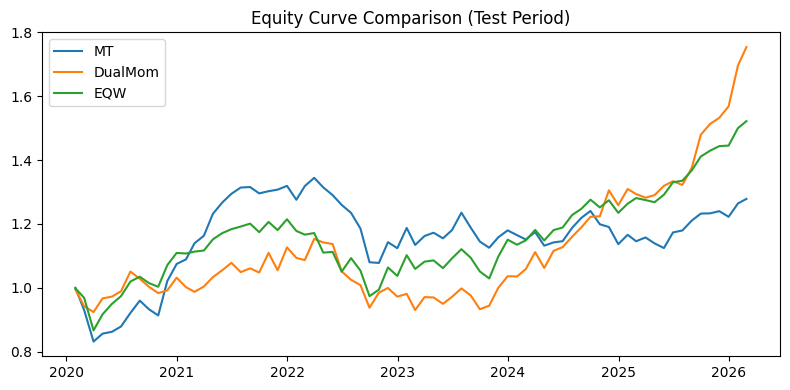

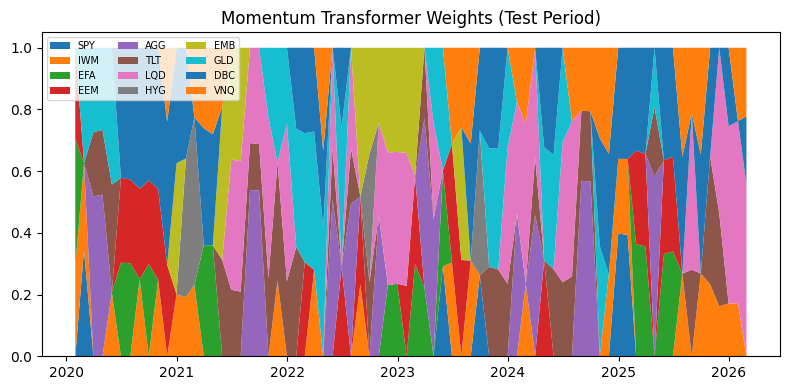

In [53]:
# エクイティカーブ比較
cum = (1 + returns_test[["MT", "DualMom", "EQW"]]).cumprod()

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
for col in cum.columns:
    ax.plot(cum.index, cum[col], label=col)
ax.set_title("Equity Curve Comparison (Test Period)")
ax.legend()
fig.savefig(FIG_DIR / "equity_curve_compare.png", dpi=150)
plt.show()

# MTのウェイト推移
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
mt_w = weights["MT"].loc[returns_test.index]
ax.stackplot(mt_w.index, mt_w.T, labels=mt_w.columns)
ax.set_title("Momentum Transformer Weights (Test Period)")
ax.legend(loc="upper left", fontsize=7, ncol=3)
fig.savefig(FIG_DIR / "weights_stack.png", dpi=150)
plt.show()


## Results

- `outputs/figures/equity_curve_compare.png` にEQW / DualMom / MTの比較を保存
- `outputs/figures/weights_stack.png` にMTのウェイト推移を保存
- `outputs/tables/perf_table.csv` にパフォーマンス指標を保存

メモ:
- `TRAIN_PARAMS["lambda_turnover"]` を 0.001〜0.05 で調整し、ターンオーバー抑制効果を確認してください。
